In [6]:
from data_pipeline import *
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from clustering import *
import seaborn as sns
import scipy.stats as stats

In [7]:
root_gene = 'CRP'
minimum_evidence = 'weak'
max_depth = np.inf
r_expr, gene_symbols, sample_names = load_data(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)
nb_genes = len(gene_symbols)
synthetic_name = 'EColi_n{}_r{}_e{}_d{}'.format(len(gene_symbols), root_gene, minimum_evidence, max_depth)
s_expr, s_gs = load_synthetic(synthetic_name)

assert (np.array(gene_symbols) == np.array(s_gs)).all()

# Split data into train and test sets
train_idxs, test_idxs = split_train_test(sample_names)
expr_train = r_expr[train_idxs, :]
expr_test = r_expr[test_idxs, :]

# Clip outliers
r_min = np.min(expr_train)
r_max = np.max(expr_train)
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max


Found 4297 genes in datafile
Found 1208 genes in CRP regulatory network
4297 genes not in gene subset. Selecting 1076 genes ...


# Intensity histograms

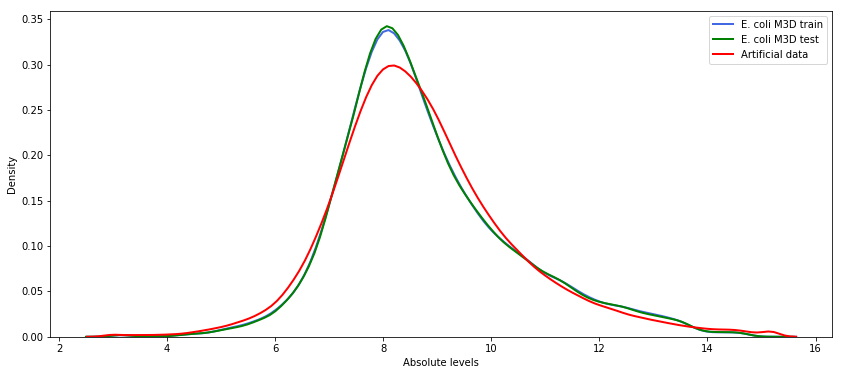

In [8]:
plt.figure(figsize=(14, 6))
ax = plot_intensities(expr_train, dataset_name='E. coli M3D train', plot_quantiles=False)
ax = plot_intensities(expr_test, dataset_name='E. coli M3D test', color='green',  plot_quantiles=False, ax=ax)
plot_intensities(s_expr, dataset_name='Artificial data', color='red', plot_quantiles=False, ax=ax);

# Gene ranges histograms

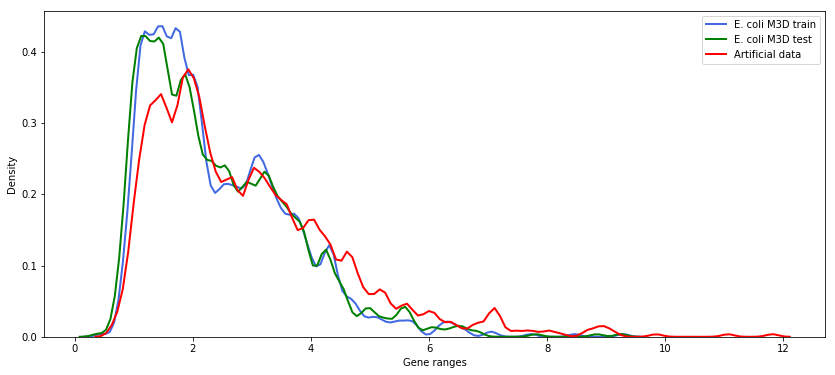

In [9]:
plt.figure(figsize=(14, 6))
ax = plot_gene_ranges(expr_train, dataset_name='E. coli M3D train')
ax = plot_gene_ranges(expr_test, dataset_name='E. coli M3D test', color='green', ax=ax)
plot_gene_ranges(s_expr, dataset_name='Artificial data', color='red', ax=ax);

# TF-TG histogram (using synthetic background distribution)

In [11]:
train_tf_tg_corr, train_tg_tg_corr = compute_tf_tg_corrs(expr_train, gene_symbols)
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(expr_test, gene_symbols)
s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(s_expr, gene_symbols)
train_back_corr = correlations_list(expr_train, expr_train)
r_back_corr = correlations_list(expr_test, expr_test)
s_back_corr = correlations_list(s_expr, s_expr)

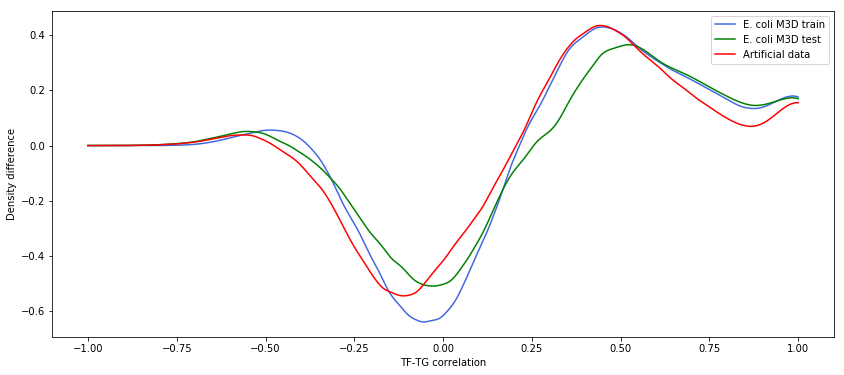

In [14]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(train_tf_tg_corr, train_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D train')
ax = plot_difference_histogram(r_tf_tg_corr, r_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D test', color='green', ax=ax)
plot_difference_histogram(s_tf_tg_corr, s_back_corr, 'TF-TG correlation', dataset_name='Artificial data', color='red', ax=ax); 

# TG-TG histogram (using synthetic background distribution)

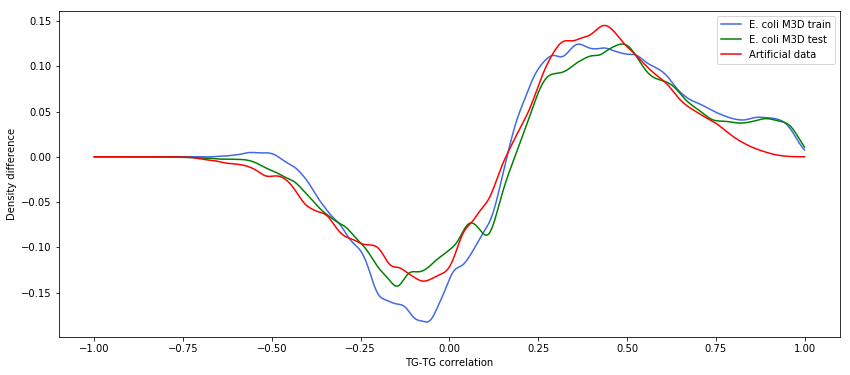

In [15]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(train_tg_tg_corr, train_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D train')
ax = plot_difference_histogram(r_tg_tg_corr, r_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D test', color='green', ax=ax)
plot_difference_histogram(s_tg_tg_corr, s_back_corr, 'TG-TG correlation', dataset_name='Artificial data', color='red', ax=ax);

# Compare background distributions

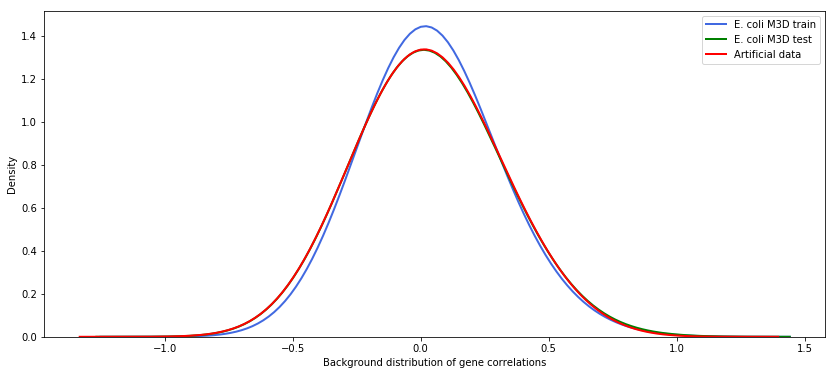

In [12]:
plt.figure(figsize=(14, 6))
ax = plot_distribution(train_back_corr, label='E. coli M3D train')
ax = plot_distribution(r_back_corr, color='green', label='E. coli M3D test', ax=ax)
plot_distribution(s_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='Artificial data', color='red');

# TF activity histogram

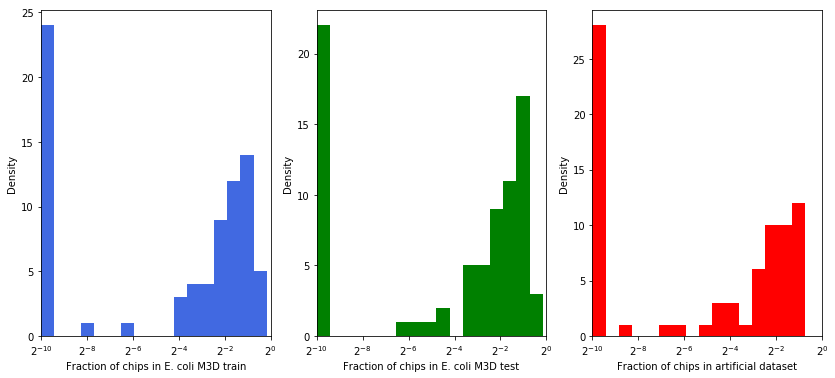

In [5]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plot_tf_activity_histogram(expr_train, gene_symbols, xlabel='Fraction of chips in E. coli M3D train')
plt.subplot(132)
plot_tf_activity_histogram(expr_test, gene_symbols, xlabel='Fraction of chips in E. coli M3D test', color='green')
plt.subplot(133)
plot_tf_activity_histogram(s_expr, gene_symbols, xlabel='Fraction of chips in artificial dataset', color='red');

# Cophenetic coefficients

In [13]:
gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz = gamma_coefficients(expr_test, s_expr)
print('Gamma(D^X, D^Z): {}'.format(gamma_dx_dz))
print('Gamma(D^X, T^X): {}'.format(gamma_dx_tx))
print('Gamma(D^Z, T^Z): {}'.format(gamma_dz_tz))
print('Gamma(T^X, T^Z): {}'.format(gamma_tx_tz))

r_tf_tg_corr_flat, r_tg_tg_corr_flat = compute_tf_tg_corrs(expr_test, gene_symbols, flat=False)
s_tf_tg_corr_flat, s_tg_tg_corr_flat = compute_tf_tg_corrs(s_expr, gene_symbols, flat=False)
psi_dx_dz = psi_coefficient(r_tf_tg_corr_flat, s_tf_tg_corr_flat)
theta_dx_dz = theta_coefficient(r_tg_tg_corr_flat, s_tg_tg_corr_flat)
print('Psi(D^X, D^Z): {}'.format(psi_dx_dz))
print('Theta(D^X, D^Z): {}'.format(theta_dx_dz))

Gamma(D^X, D^Z): 0.8201949247413899
Gamma(D^X, T^X): 0.5456429177501786
Gamma(D^Z, T^Z): 0.5368094967679798
Gamma(T^X, T^Z): 0.42201102283243525
Psi(D^X, D^Z): 0.8502856065941766
Theta(D^X, D^Z): 0.8508195260768167


# Analyze gene histograms

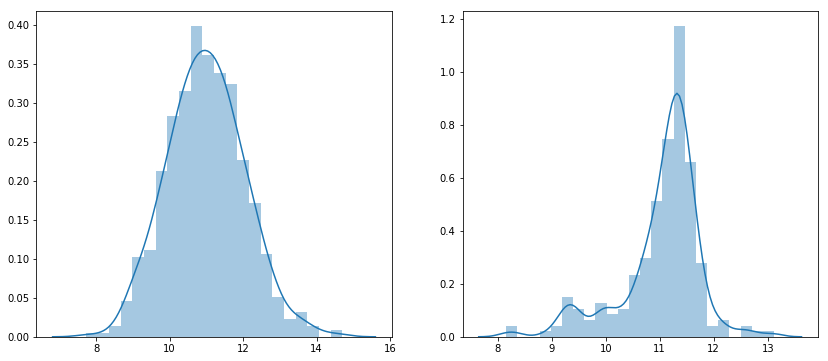

In [22]:
crp_idx = np.argwhere(np.array(gene_symbols) == 'crp')
idx = crp_idx
plt.figure(figsize=(14, 6))
plt.title('Expression levels of CRP');
plt.subplot(121)
ax = sns.distplot(s_expr[:, idx])
plt.subplot(122)
ax = sns.distplot(expr_test[:, idx])

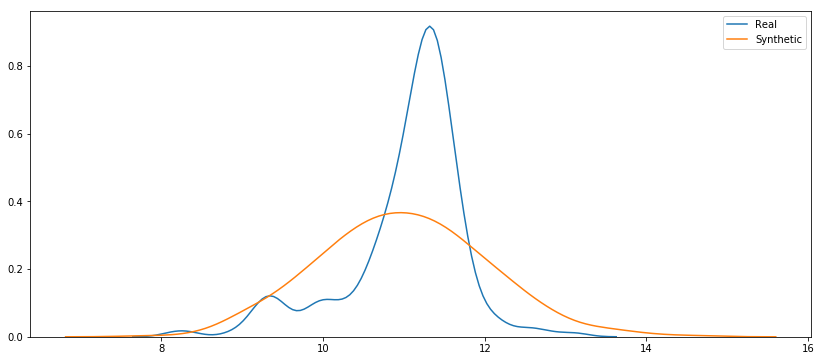

In [23]:
plt.figure(figsize=(14, 6))
r_expr_gene = expr_test[:, crp_idx]
s_expr_gene = s_expr[:, crp_idx]
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')

In [24]:
diag = np.diag(np.ones(nb_genes))
r_corr = pearson_correlation(expr_test, expr_test) - diag
s_corr = pearson_correlation(s_expr, s_expr) - diag
crp_idx = np.argwhere(np.array(gene_symbols) == 'crp').ravel()

In [25]:
r_corr_crp = r_corr[crp_idx, :].ravel()
s_corr_crp = s_corr[crp_idx, :].ravel()
r_max_corr_crp = np.max(r_corr_crp)
s_max_corr_crp = np.max(s_corr_crp)
sorted_idxs = np.argsort(r_corr_crp)[::-1]
print('CRP max correlated ({:.4f}) gene: {}'.format(r_max_corr_crp, gene_symbols[sorted_idxs[0]]))
print('CRP correlation with {} in synthetic: {}'.format(gene_symbols[sorted_idxs[0]], s_corr_crp[sorted_idxs[0]]))

CRP max correlated (0.7841) gene: tolc
CRP correlation with tolc in synthetic: 0.5460312192268822


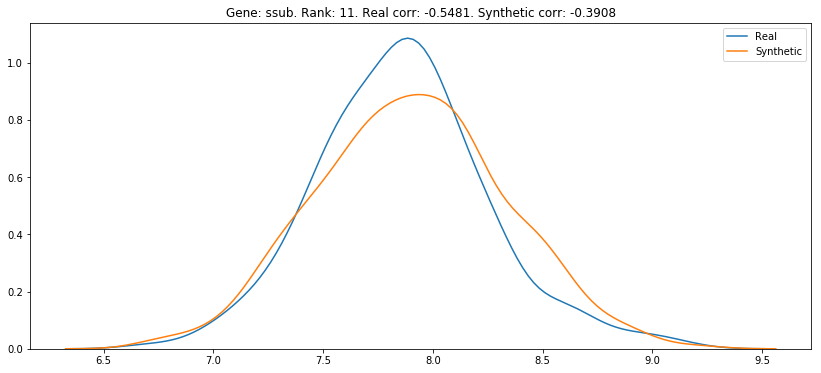

In [26]:
idx = -11
plt.figure(figsize=(14, 6))
r_expr_gene = expr_test[:, sorted_idxs[idx]]
s_expr_gene = s_expr[:, sorted_idxs[idx]]
plt.title('Gene: {}. Rank: {}. Real corr: {:.4f}. Synthetic corr: {:.4f}'.format(gene_symbols[sorted_idxs[idx]],
                                                                          max(idx+1, abs(idx)),
                                                                          r_corr_crp[sorted_idxs[idx]],
                                                                          s_corr_crp[sorted_idxs[idx]]))
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')

# Master regulators' histograms

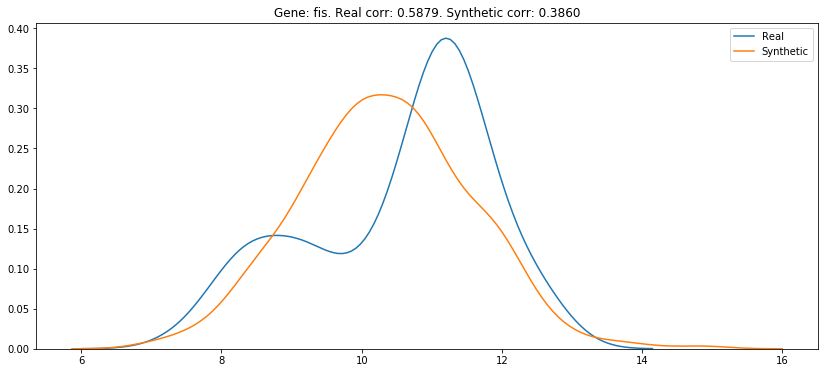

In [27]:
master_regulators = ['fis', 'hns', 'lrp', 'fnr', 'arca']
idx = 0
idx = np.argwhere(np.array(gene_symbols) == master_regulators[idx]).ravel()[0]
plt.figure(figsize=(14, 6))
r_expr_gene = expr_test[:, idx]
s_expr_gene = s_expr[:, idx]
plt.title('Gene: {}. Real corr: {:.4f}. Synthetic corr: {:.4f}'.format(gene_symbols[idx],
                                                                          r_corr_crp[idx],
                                                                          s_corr_crp[idx]))
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')